<a href="https://colab.research.google.com/github/chaitanya-sharma/cnn_cifar10/blob/main/CIFAR10VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing the data

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
torch.__version__

'2.0.0+cu118'

In [ ]:
train_data=datasets.CIFAR10('data', True, ToTensor(), None, True)

test_data=datasets.CIFAR10('data', False, ToTensor(), None, True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
len(train_data), len(test_data)

(50000, 10000)

In [ ]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
image, label=train_data[0]

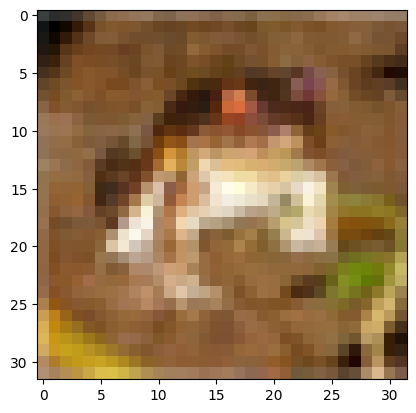

In [ ]:
plt.imshow(image.permute(1,2,0))

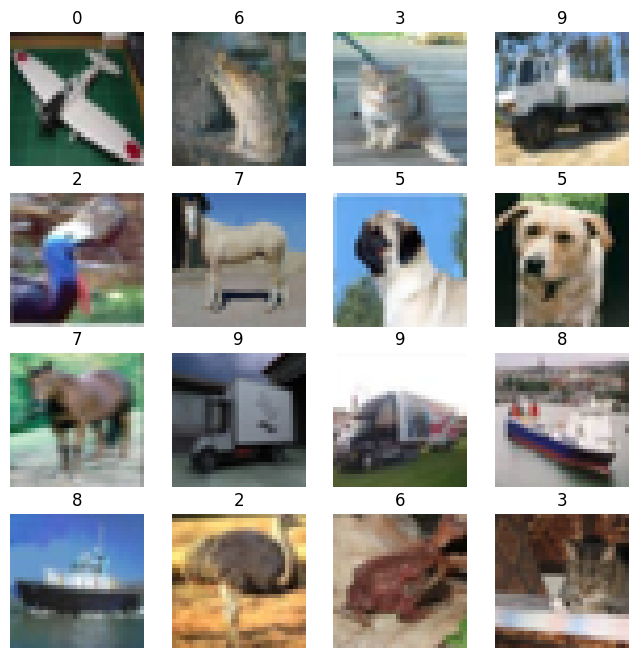

In [ ]:
torch.manual_seed(42)

figure=plt.figure(figsize=(8,8))
cols, rows=4, 4

for i in range(1, rows*cols+1):
  random_idx=np.random.randint(0, len(train_data))
  image, label=train_data[random_idx]
  figure.add_subplot(rows, cols, i)
  plt.imshow(image.permute(1,2,0), cmap="gray")
  plt.axis(False)
  plt.title(label)

In [ ]:
from torch.utils.data import DataLoader

train_dataloader=DataLoader(train_data, batch_size=32, shuffle=True)

test_dataloader=DataLoader(test_data, 32, True)

In [ ]:
len(train_dataloader), len(test_dataloader)

(1563, 313)

In [ ]:
image.shape

torch.Size([3, 32, 32])

In [ ]:
train_data.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

### Model 0: Linear

In [ ]:
class CIFAR10Model0(nn.Module):
  def __init__(self, input_shape, output_shape, hidden_units):
    super().__init__()
    self.Linear_Stack=nn.Sequential(
                                    nn.Flatten(),
                                    nn.Linear(input_shape, hidden_units),
                                    nn.Linear(hidden_units, hidden_units),
                                    nn.Linear(hidden_units, output_shape))
  def forward(self, x):
    return self.Linear_Stack(x)

In [ ]:
Model_0=CIFAR10Model0(3072, len(train_data.classes), 10)
Model_0

CIFAR10Model0(
  (Linear_Stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [ ]:
# Loss Function and Optimizer

loss_fn=nn.CrossEntropyLoss()

optimizer=torch.optim.SGD(lr=0.01,
                          params=Model_0.parameters())

In [ ]:
def accuracy_fn(y_true, y_pred):
  correct=torch.eq(y_true, y_pred).sum().item()
  acc=correct/len(y_true)
  return acc*100

In [ ]:
from timeit import default_timer as timer
def print_train_time(start, end, device: torch.device=device):
  time=end-start
  print(f"The total time taken to train on {device} is {time}")
  return time

In [ ]:
from tqdm.auto import tqdm

torch.manual_seed(42)
start_time=timer()

num_epochs=5

for epoch in range(num_epochs):
  print(f"Epoch: {epoch}\n-------")
  Model_0.train()
  train_loss, train_acc= 0, 0
  for batch, (X,y) in enumerate(train_dataloader):
    preds=Model_0(X)

    loss=loss_fn(preds, y)
    train_loss+=loss

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

  train_loss/=len(train_dataloader)

  test_acc, test_loss = 0,0
  with torch.inference_mode():
    for X, y in (test_dataloader):
      test_preds=Model_0(X)

      loss=loss_fn(test_preds, y)
      test_loss+=loss

      acc=accuracy_fn(y, test_preds.argmax(dim=1))
      test_acc+=acc

    test_acc/=len(test_dataloader)
    test_loss/=len(test_dataloader)


  print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

end_time=timer()

print_train_time(start_time, end_time, "cpu")

Epoch: 0
-------

Train loss: 2.00971 | Test loss: 1.91750, Test acc: 30.68%

Epoch: 1
-------

Train loss: 1.85425 | Test loss: 1.85163, Test acc: 34.16%

Epoch: 2
-------

Train loss: 1.81400 | Test loss: 1.81621, Test acc: 35.80%

Epoch: 3
-------

Train loss: 1.79051 | Test loss: 1.88137, Test acc: 33.63%

Epoch: 4
-------

Train loss: 1.77342 | Test loss: 1.78967, Test acc: 36.75%

The total time taken to train on cpu is 53.73690484599956


53.73690484599956

### Functionizing the training and testing step

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device=device):
  model.train()

  train_loss, train_acc=0,0
  for batch, (X, y) in enumerate(dataloader):

    X, y=X.to(device), y.to(device)
    preds=model(X)

    loss=loss_fn(preds, y)
    train_loss+=loss

    acc=accuracy_fn(y, preds.argmax(dim=1))
    train_acc+=acc

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

  train_loss/=len(dataloader)
  train_acc/=len(dataloader)

  print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accurcay_fn,
              device: torch.device=device):

  model.eval()
  test_loss, test_acc=0,0

  with torch.inference_mode():
    for X, y in dataloader:
      # X, y=X.to(device), y.to(device)
      X, y=X.to(device), y.to(device)
      test_preds=model(X)

      loss=loss_fn(test_preds, y)
      test_loss+=loss

      acc=accuracy_fn(y, test_preds.argmax(dim=1))
      test_acc+=acc

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

### Model 1: Non Linear

In [ ]:
class CIFAR10ModelV1(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()

    self.layer_stack=nn.Sequential(
        nn.Flatten(),
        nn.Linear(input_shape, hidden_units),
        nn.Linear(hidden_units, output_shape),
        nn.ReLU()
    )

  def forward(self, x):
    return self.layer_stack(x)

In [ ]:
model_1=CIFAR10ModelV1(3072, 10, len(train_data.classes)).to(device)
model_1

CIFAR10ModelV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
  )
)

In [ ]:
loss_fn=nn.CrossEntropyLoss()

optimizer=torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01)

In [ ]:
num_epochs=3

model_1_start=timer()

for epoch in tqdm(range(num_epochs)):
  train_step(model_1, train_dataloader, loss_fn, optimizer, accuracy_fn)

  test_step(model_1, test_dataloader, loss_fn, accuracy_fn)

model_1_end=timer()

print_train_time(model_1_start, model_1_end)

  0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 2.08561 | Train accuracy: 26.11%
Test loss: 1.97448 | Test accuracy: 30.37%

Train loss: 1.89534 | Train accuracy: 34.25%
Test loss: 1.85157 | Test accuracy: 34.57%

Train loss: 1.80357 | Train accuracy: 37.14%
Test loss: 1.77195 | Test accuracy: 38.27%

The total time taken to train on cuda is 34.09025104200009


34.09025104200009

In [ ]:
def eval_model(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device=device):
  loss, acc= 0,0

  with torch.inference_mode():
    for X, y in dataloader:
      X, y=X.to(device), y.to(device)
      preds=model(X)

      loss+=loss_fn(preds, y)
      acc+=accuracy_fn(y, preds.argmax(dim=1))

    loss/=len(dataloader)
    acc/=len(dataloader)

  return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}

In [ ]:
model0_results=eval_model(Model_0, test_dataloader, loss_fn, accuracy_fn,"cpu")
model0_results

{'model_name': 'CIFAR10Model0',
 'model_loss': 1.7891430854797363,
 'model_acc': 36.781150159744406}

In [ ]:
model1_results=eval_model(model_1, test_dataloader, loss_fn, accuracy_fn)
model1_results

{'model_name': 'CIFAR10ModelV1',
 'model_loss': 1.7720699310302734,
 'model_acc': 38.25878594249201}

## Model 2: CNN

In [ ]:
class CIFAR10ModelV2(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()

    self.block_1=nn.Sequential(
        nn.Conv2d(input_shape, hidden_units, 3, 1, 1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, 3, 1, 1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
    )

    self.block_2=nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, 3, 1, 1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, 3, 1, 1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
    )

    self.classifier=nn.Sequential(
        nn.Flatten(),
        nn.Linear(hidden_units*8*8, output_shape)
    )

  def forward(self, x):
    x=self.block_1(x)
    # print(x.shape)
    x=self.block_2(x)
    # print(x.shape)
    x=self.classifier(x)
    # print(x.shape)
    return x

In [ ]:
model_2=CIFAR10ModelV2(3, 64, 10).to(device)
model_2

CIFAR10ModelV2(
  (block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=10, bias=True)
  )
)

In [ ]:
loss_fn=nn.CrossEntropyLoss()

optimizer=torch.optim.SGD(lr=0.068, params=model_2.parameters())

In [ ]:
torch.manual_seed(42)

num_epochs=5

model_2_start=timer()

for epoch in tqdm(range(num_epochs)):
  train_step(model_2, train_dataloader, loss_fn, optimizer, accuracy_fn)

  test_step(model_2, test_dataloader, loss_fn, accuracy_fn, "cuda")

model_2_end=timer()

print_train_time(model_2_start, model_2_end)

  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.62091 | Train accuracy: 78.35%
Test loss: 0.94088 | Test accuracy: 69.18%

Train loss: 0.56317 | Train accuracy: 80.30%
Test loss: 0.92182 | Test accuracy: 69.73%

Train loss: 0.51018 | Train accuracy: 82.33%
Test loss: 0.89586 | Test accuracy: 71.62%

Train loss: 0.47467 | Train accuracy: 83.42%
Test loss: 0.87118 | Test accuracy: 72.56%

Train loss: 0.43164 | Train accuracy: 84.89%
Test loss: 0.92986 | Test accuracy: 71.44%

The total time taken to train on cuda is 70.99125032499978


70.99125032499978

In [ ]:
model_2_result=eval_model(model_2, test_dataloader, loss_fn, accuracy_fn)
model_2_result

{'model_name': 'CIFAR10ModelV2',
 'model_loss': 0.9296021461486816,
 'model_acc': 71.46565495207668}

In [ ]:
model0_results

{'model_name': 'CIFAR10Model0',
 'model_loss': 1.7891430854797363,
 'model_acc': 36.781150159744406}

In [ ]:
model1_results

{'model_name': 'CIFAR10ModelV1',
 'model_loss': 1.7720699310302734,
 'model_acc': 38.25878594249201}